In [15]:
from read_datasetBreakfast import load_data, read_mapping_dict
import os
import numpy as np


COMP_PATH = ''

''' 
training to load train set
test to load test set
'''
split = 'training'
#split = 'test'
train_split =  os.path.join(COMP_PATH, 'splits/dev_train.split1.bundle') #Train Split
test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video 
DATA_folder =  os.path.join(COMP_PATH, 'Data/') #Frame I3D features for all videos
mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt') 

actions_dict = read_mapping_dict(mapping_loc)

data_feat, data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = split) #Get features and labels

Finish Load the Training data and labels!!!


In [16]:
import torch
new_data_feat = []
new_data_labels = []
frames_per_seg = 15
for i in range(0, len(data_feat)):
    total_frames, dim = data_feat[i].shape
    segment_num = int(total_frames / frames_per_seg)
    segments = data_feat[i][:segment_num * frames_per_seg].view(-1, frames_per_seg, 400)
    labels = torch.LongTensor([data_labels[i][:segment_num * frames_per_seg]]).view(-1, frames_per_seg)
    
    new_data_feat.append(segments)
    new_data_labels.append(labels)
    
new_data_feat = torch.cat(new_data_feat)
new_data_labels = torch.cat(new_data_labels)



In [17]:
from Dataset.VideoDataset import VideoDataset
import torch.utils.data as tud
from Models.LSTM import LSTM_Model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

epochs = 2
batch_size = 20

dataset = VideoDataset(new_data_feat, new_data_labels)
dataloader = tud.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = LSTM_Model()
learning_rate = 1e-3
log_interval = 50

def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    
    losses = []
    scores = []
    for batch_idx, (in_feature, label) in enumerate(train_loader):
        in_feature = in_feature.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = model(in_feature)
        output = output.view(-1, 48)
        label = label.flatten()
        loss = F.cross_entropy(output, label)
        losses.append(loss.item())
        
        label_predict = torch.max(output, 1)[1]
        step_score = accuracy_score(label.cpu().data.squeeze().numpy(), label_predict.cpu().data.squeeze().numpy())
        scores.append(step_score)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, (batch_idx+1)*batch_size, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))
        
    return losses, scores

In [18]:
cuda_avail = torch.cuda.is_available()
device = torch.device("cuda" if cuda_avail else "cpu")

lstm = LSTM_Model().double().to(device)
optimizer = torch.optim.Adam(list(lstm.parameters()), lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_train_scores = []
for epoch in range(epochs):
    train_losses, train_scores = train(log_interval, lstm, device, dataloader, optimizer, epoch)
    
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    np.save('./training_losses.npy', A)
    np.save('./training_scores.npy', B)
    

Train Epoch: 1 [1000/25045 (4%)]	Loss: 3.227982, Accu: 17.33%
Train Epoch: 1 [2000/25045 (8%)]	Loss: 3.048983, Accu: 12.33%
Train Epoch: 1 [3000/25045 (12%)]	Loss: 2.737498, Accu: 18.00%
Train Epoch: 1 [4000/25045 (16%)]	Loss: 3.282625, Accu: 17.00%
Train Epoch: 1 [5000/25045 (20%)]	Loss: 2.992332, Accu: 15.67%
Train Epoch: 1 [6000/25045 (24%)]	Loss: 3.133088, Accu: 5.00%
Train Epoch: 1 [7000/25045 (28%)]	Loss: 2.634096, Accu: 15.00%
Train Epoch: 1 [8000/25045 (32%)]	Loss: 2.925687, Accu: 28.00%
Train Epoch: 1 [9000/25045 (36%)]	Loss: 2.600398, Accu: 26.00%
Train Epoch: 1 [10000/25045 (40%)]	Loss: 2.775905, Accu: 20.67%
Train Epoch: 1 [11000/25045 (44%)]	Loss: 2.562516, Accu: 20.67%
Train Epoch: 1 [12000/25045 (48%)]	Loss: 2.648181, Accu: 31.00%
Train Epoch: 1 [13000/25045 (52%)]	Loss: 2.311989, Accu: 15.33%
Train Epoch: 1 [14000/25045 (56%)]	Loss: 2.673244, Accu: 17.00%
Train Epoch: 1 [15000/25045 (60%)]	Loss: 2.508484, Accu: 33.67%
Train Epoch: 1 [16000/25045 (64%)]	Loss: 2.034332, A

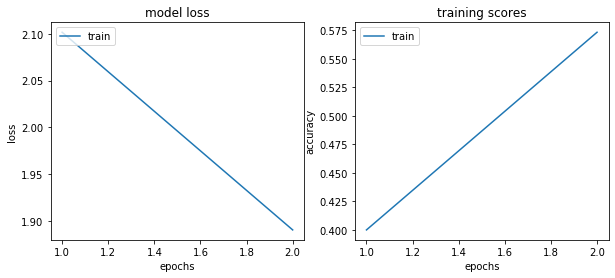

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train'], loc="upper left")
# 2nd figure
plt.subplot(122)
plt.plot(np.arange(1, epochs + 1), B[:, -1])  # train accuracy (on epoch end)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train'], loc="upper left")
plt.show()
     